# 01 - Generate Slabs

This notebook generates output files containing slab points that have been projected from the trench. 

In [1]:
import math
import pandas as pd
import geopandas as gpd
import cartopy.crs as ccrs
import os
import shutil
import gplately
from gplately import pygplates
import matplotlib.pyplot as plt
import numpy as np
import ptt  # plate tectonic tools
import warnings
from joblib import Parallel, delayed
from slabdip import SlabDipper

import slab_tracker_utils as slab
import splits_and_merges as snm

warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

In [2]:
## Load Plate Model:
plate_model_dir = 'input_data/EarthByte_STELLAR_Plate_Motion_Model-Phase2'

rotation_model = pygplates.RotationModel('{}/CombinedRotations.rot'.format(plate_model_dir))

GPML_List = ['{}/Feature_Geometries.gpml'.format(plate_model_dir),
             '{}/Plate_Boundaries.gpml'.format(plate_model_dir),
             '{}/Flat_Slabs.gpml'.format(plate_model_dir),
             '{}/Deforming_Networks_Active.gpml'.format(plate_model_dir),
             '{}/Deforming_Networks_Inactive.gpml'.format(plate_model_dir)]

static_polygons = pygplates.FeatureCollection(
    '{}/StaticGeometries/StaticPolygons/Global_EarthByte_GPlates_PresentDay_StaticPlatePolygons.shp'.format(plate_model_dir))
coastlines = pygplates.FeatureCollection(
    '{}/StaticGeometries/Coastlines/Global_coastlines_low_res.shp'.format(plate_model_dir))
continents = pygplates.FeatureCollection(
    '{}/StaticGeometries/ContinentalPolygons/Global_EarthByte_GPlates_PresentDay_ContinentsAndArcs.shp'.format(plate_model_dir))

topology_features = pygplates.FeatureCollection()
for file in GPML_List:
    topology_feature = pygplates.FeatureCollection(file)
    topology_features.add(topology_feature)


model = gplately.PlateReconstruction(rotation_model, topology_features, static_polygons, anchor_plate_id=702702)
gplot = gplately.PlotTopologies(model, coastlines, continents, anchor_plate_id=702702)

## specify the convention for agegrids
## assumes that the file name has 1 number within it that specifies the age in Myr
agegrid_filename = plate_model_dir+'/EarthByte_Plate_Motion_Model-Phase2-SeafloorAgeGrids-MantleFrame-NC/EarthByte_Plate_Motion_Model-Phase2-MantleReferenceFrame-{:.0f}.nc'
spreadrate_filename = plate_model_dir+'/EarthByte_Plate_Motion_Model-Phase2-SpreadingRateGrids-MantleFrame-NC/EarthByte_STELLAR_Plate_Motion_Model-Phase2_SPREADING_RATE_grid_{:.1f}Ma.nc'

## If you do not have age grids, use the next line instead:
## Note: cannot extract slabdip data without age grids
# agegrid_filename = None

## Define Input Parameters
**Time Range:**

To look at subducting slab between 15 and 0Ma in 1myr intervals;
* Specify `start_time` as 15
* Specify `end_time` as 0
* Specify `time_step` as 1

**Bin Time:**

At any given time, the subducting slab is made up of points that have already been subducted prior to the current timestep. In order to visualise the subducting slab at a given time, we need to set the `bin_time`. This variable refers to how many (million) years of previous slab points that we want to display - or the number of rows of slab displayed on the map.  

For example, we want to view subducting slabs at 10Ma and `bin_time = 5`. We first locate all subduction boundary points at 15Ma, and project these points in the direction of the downgoing slab to their estimated location at 10Ma. Then we go back to 14Ma, find all trench points and project them to their estimated location at 10Ma, and so on, until we reach 10Ma. When we plot all of these points, we will see an estimate of the slab that has been subducting during the period from 15Ma to 10Ma. 

**Dip Angle:**

This workflow can be run using a constant dip angle for all subducting slabs (e.g. 45 degrees) or using slab dip data extracted from the model using the `slabdip` package. Usage and installation info for this package can be found at https://github.com/brmather/Slab-Dip/tree/main.

Set `use_constant_dip_angle` to `True` to use one dip angle for all trench points, or `False` to use variable dip angles. 

In [3]:
start_time = 45
end_time = 0
time_step = 1.0
time_range = np.arange(start_time, end_time-time_step, -time_step)
bin_time = 5

use_constant_dip_angle = False
if use_constant_dip_angle:
    dip_angle_degrees = 45.0
    dip_label = f'{dip_angle_degrees:0.0f}deg'
else:
    dip_label = 'variable'
    ## Initialise SlabDipper object and set filename paths of seafloor age and spreading rate grids
    dipper = SlabDipper()
    dipper.model = model
    dipper.set_age_grid_filename(agegrid_filename)
    dipper.set_spreading_rate_grid_filename(spreadrate_filename)

line_tessellation_distance = np.radians(0.5)
handle_splits = False

## To use small circle path for stage rotation to rotate along velocity dip. 
## (i.e. distance to stage rotation pole matches distance to original stage pole.
use_small_circle_path = False

## Set directory for output files 
## (NOTE: Change this if doing multiple runs with different parameters otherwise it will overwrite previous files!!)
out_dir = "output_data"
os.makedirs(out_dir, exist_ok=True)

## Project Slab Points

In [4]:
def get_slabdip_data(df_slabdip, tessellated_line, reconstruction_time):
    """ Function that takes a subduction boundary segment line and extracts the slab dip angle of its points."""
    
    slabdip_lons = df_slabdip['lon']
    slabdip_lats = df_slabdip['lat']
    slabdip_angles = df_slabdip['slab_dip'].to_numpy(dtype=float)

    slabdip_points = []
    for slon, slat in zip(slabdip_lons, slabdip_lats):
        slabdip_points.append(pygplates.PointOnSphere((slat, slon)))

    polyline_points = [point for point in tessellated_line]
    
    closest_point_index = []
    for lpoint in polyline_points:
        dists = np.empty(len(slabdip_points))
        
        for i, spoint in enumerate(slabdip_points):
            dists[i] = pygplates.GeometryOnSphere.distance(lpoint, spoint)

        closest_point_index.append(np.argmin(dists))

    point_slabdip_angle = slabdip_angles[closest_point_index]
    # points_slabdip_angle_radians = np.radians(points_slabdip_angle)

    return point_slabdip_angle

In [5]:
def subducting_slab(reconstruction_time, bin_time, time_step):

    time_list = np.arange(reconstruction_time + (bin_time * time_step), reconstruction_time - time_step, -time_step)
    end_time = reconstruction_time - time_step

    output_filename = '{}/subduction_3d_geometries_{:03.0f}Ma_dip_{}.asc'.format(out_dir, reconstruction_time, dip_label)
    output_data = []
    
    if handle_splits:
        plate_disappearance_time_lut = snm.get_plate_disappearance_time_lut(topology_features, rotation_model, time_list, verbose=True)
        print(plate_disappearance_time_lut)
    
    for time in time_list:
        ## Call function to get subduction boundary segments
        subduction_boundary_sections = slab.getSubductionBoundarySections(topology_features, rotation_model, time)

        if agegrid_filename is not None:
            ## Set up an age grid interpolator for this time, to be used for each tessellated line segment
            grdfile = agegrid_filename.format(time)
            lut = slab.make_age_interpolator(grdfile)

        if not use_constant_dip_angle:
            ## Estimate slab dip across the globe for a specified reconstruction time (returned as a Pandas DataFrame)
            df_slabdip = dipper.tessellate_slab_dip(reconstruction_time) # tessellation_threshold_radians=np.radians(0.5)
    
        ## Loop over each segment
        for segment_index, subduction_segment in enumerate(subduction_boundary_sections):
        
            ## Find the overriding plate id (and only continue if we find it)
            overriding_and_subducting_plates = slab.find_subducting_plate(subduction_segment, False)
        
            if not overriding_and_subducting_plates:
                continue
                
            overriding_plate, subducting_plate, subduction_polarity = overriding_and_subducting_plates
            overriding_plate_id = overriding_plate.get_resolved_feature().get_reconstruction_plate_id()
            subducting_plate_id = subducting_plate.get_resolved_feature().get_reconstruction_plate_id()
        
            subducting_plate_disappearance_time = -1.
            if handle_splits:
                for plate_disappearance in plate_disappearance_time_lut:
                    if plate_disappearance[0] == subducting_plate_id:
                        subducting_plate_disappearance_time = plate_disappearance[1]
        
            tessellated_line = subduction_segment.get_resolved_geometry().to_tessellated(line_tessellation_distance)

            if use_constant_dip_angle:
                point_slabdip_angles = np.tile(dip_angle_degrees, len(tessellated_line))
            else:
                point_slabdip_angles = get_slabdip_data(df_slabdip, tessellated_line, time)
            
            if agegrid_filename is not None:
                x = tessellated_line.to_lat_lon_array()[:, 1]
                y = tessellated_line.to_lat_lon_array()[:, 0]
                subduction_ages = lut.ev(np.radians(y + 90.), np.radians(x + 180.))
            else:
                ## If no age grids, just fill the ages with zero
                subduction_ages = [0. for point in tessellated_line.to_lat_lon_array()[:, 1]]
        
            ## CALL THE MAIN WARPING FUNCTION
            (points, point_depths, polyline, point_slabdip) = slab.warp_subduction_segment(tessellated_line, rotation_model, subducting_plate_id, 
                                                                                           overriding_plate_id, subduction_polarity, time, end_time, 
                                                                                           time_step, point_slabdip_angles, 
                                                                                           subducting_plate_disappearance_time,
                                                                                           use_small_circle_path)
        
            output_data.append([time, polyline, point_depths, subduction_ages, point_slabdip, segment_index])

    slab.write_subducted_slabs_to_xyz(output_filename, output_data)
    
    return

## Generate Output Files
Generate one output file per timestep in time range (This takes quite a while). 

In [13]:
## --- Run Normally ---
for reconstruction_time in time_range:
    subducting_slab(reconstruction_time, bin_time, time_step)
    print(reconstruction_time)

## --- Run in Parallel ---
# _ = Parallel(n_jobs=-3, backend='loky', verbose=1)\
# (delayed(subducting_slab)(reconstruction_time, bin_time, time_step) for reconstruction_time in time_range)

45.0
44.0
43.0
42.0
41.0
40.0
39.0
38.0
37.0
36.0
35.0
34.0
33.0
32.0
31.0
30.0
29.0
28.0
27.0
26.0
25.0
24.0
23.0
22.0
21.0
20.0
19.0
18.0
17.0
16.0
15.0
14.0
13.0
12.0
11.0
10.0
9.0
8.0
7.0
6.0
5.0
4.0
3.0
2.0
1.0
0.0


## Plot One Timestep
To check output before moving on to notebook 02.

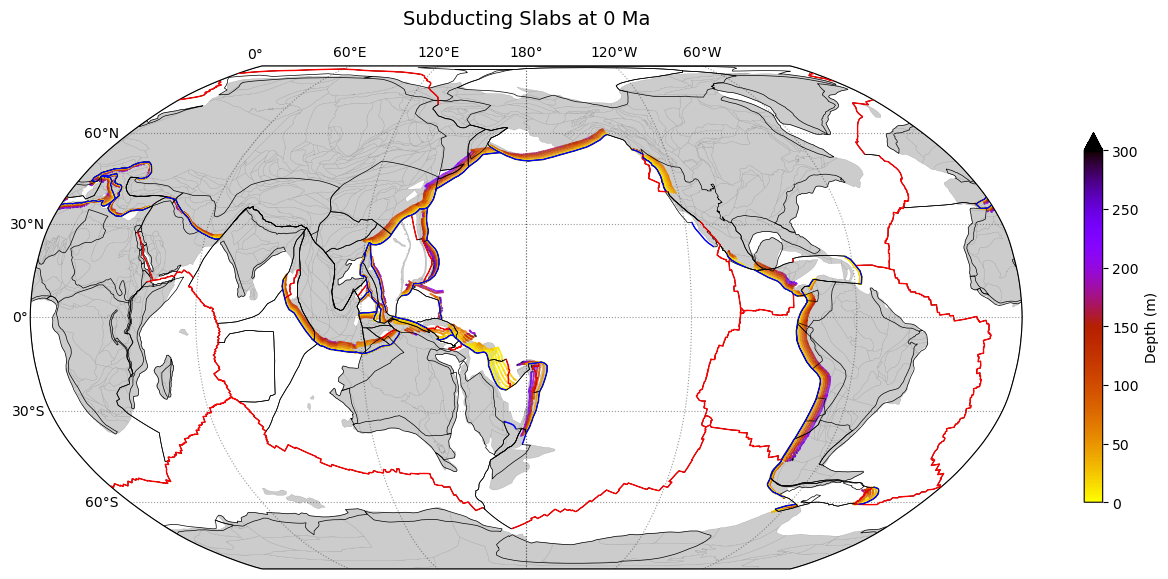

In [14]:
reconstruction_time = 0

output_filename = '{}/subduction_3d_geometries_{:03.0f}Ma_dip_{}.asc'.format(out_dir, reconstruction_time, dip_label)
slab_data = np.loadtxt(output_filename, delimiter=',', skiprows=1)
slab_lons = slab_data[:,0]
slab_lats = slab_data[:,1]
depths = slab_data[:,2]

fig = plt.figure(figsize=(16, 8))

ax = fig.add_subplot(111, projection=ccrs.Robinson(central_longitude=180), facecolor='none')
gl = ax.gridlines(crs=ccrs.PlateCarree(), color='0.2', linestyle=':', draw_labels=True, alpha=0.5)
gl.bottom_labels = None
ax.set_global()

gplot.time = reconstruction_time # Ma
gplot.plot_continents(ax, facecolor='0.8', edgecolor='0.6', linewidth=0.2)
gplot.plot_all_topologies(ax, color='k', linewidth=0.5, zorder=3)
gplot.plot_ridges_and_transforms(ax, color='red', linewidth=1, zorder=4)
gplot.plot_trenches(ax, color='blue', linewidth=1, zorder=4)
# gplot.plot_subduction_teeth(ax, color='blue', linewidth=0.65, zorder=4)
# gplot.plot_plate_motion_vectors(ax, spacingX=10, spacingY=10, color='k', alpha=1.0/3, zorder=8)

sc = ax.scatter(slab_lons, slab_lats, transform=ccrs.PlateCarree(), s=0.2, c=depths, cmap='gnuplot_r', vmin=0, vmax=300, zorder=2)
fig.colorbar(sc, ax=ax, shrink=0.6, label='Depth (m)', extend='max')

plt.title(f'Subducting Slabs at {reconstruction_time} Ma', fontsize=14, pad=15)

plt.show()